In [1]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

clusters_list = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [3]:
# Test on the first 30 clusters
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
#clusters = clusters.head(50)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
117,3,25011,SRR5892449.10018,118
13,5,39243,SRR5892449.10138,14
501,2,14520,SRR5892449.10169,502
272,4,19525,SRR5892449.10199,273
682,2,8807,SRR5892449.10325,683


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

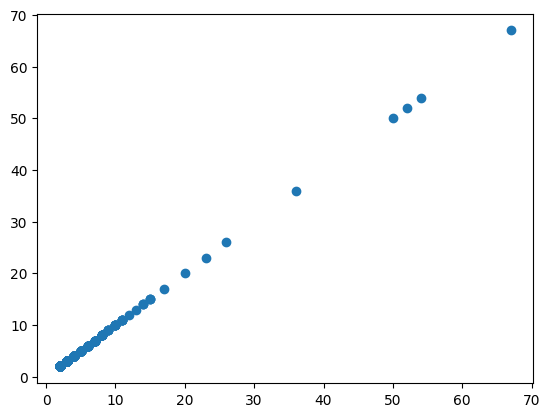

In [4]:
plt.scatter(x=clusters['coverage'], y=clusters['coverage'])

# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [5]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [6]:
convert_fq_to_fa('test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fastq','test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fasta')

11637 sequences converted to fasta


In [7]:
fasta = 'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted_reversed.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [8]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [9]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.068673,0.062148,0.036930,0.042465,0.053846,0.038121,0.039734,0.035885,0.030479,0.022378,...,0.010410,0.018492,0.010923,0.048458,0.018804,0.028591,0.024485,0.014772,0.022030,SRR5892449.19157
1,0.066762,0.058792,0.038745,0.042383,0.051517,0.035435,0.037397,0.037662,0.028671,0.025217,...,0.011321,0.018596,0.011076,0.047451,0.018085,0.029222,0.026586,0.016410,0.021416,SRR5892449.26912
2,0.070278,0.062348,0.040416,0.041634,0.046632,0.037689,0.037669,0.037648,0.032031,0.023027,...,0.009562,0.019268,0.012081,0.049812,0.021085,0.028479,0.021788,0.013527,0.021209,SRR5892449.4506
3,0.070280,0.059009,0.037563,0.043715,0.049234,0.038321,0.037774,0.034972,0.029557,0.022753,...,0.012282,0.020562,0.011334,0.047654,0.019129,0.027556,0.025196,0.017675,0.022289,SRR5892449.22810
4,0.068131,0.056952,0.038211,0.043370,0.047736,0.035917,0.038850,0.037814,0.030538,0.024518,...,0.010628,0.019138,0.011774,0.048728,0.021828,0.029810,0.024430,0.016272,0.020572,SRR5892449.26820


# Dimensionality reduction with PCA and clustering with k-means 

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [11]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [12]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([1.16492185e-03, 6.48275248e-05])

In [13]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction)

## merging the dataframe with ids and other relevant information
kmer_reduction = pd.concat([kmer_reduction, hist_df['ids']], axis=1)
kmer_reduction.rename(columns={0:'comp1',1:'comp2'}, inplace=True)
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt']=(kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage']>10]
kmer_reduction.head(10)

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,mt
6,0.250434,0.015862,SRR5892449.16013,23,42906,7,32
7,0.194896,-0.004475,SRR5892449.18856,50,42640,8,32
10,0.214927,0.012217,SRR5892449.4276,20,40403,11,32
17,0.204622,0.004961,SRR5892449.17340,15,38289,18,32
21,0.175464,0.012258,SRR5892449.21564,11,37081,22,32
28,0.223685,0.001026,SRR5892449.18969,54,35773,29,32
33,-0.001087,0.011152,SRR5892449.47933,11,34380,34,1
34,-0.010276,-0.007575,SRR5892449.46338,15,34217,35,1
36,-0.004506,0.010809,SRR5892449.27847,14,33854,37,1
41,0.119297,0.016229,SRR5892449.9739,52,33518,42,32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

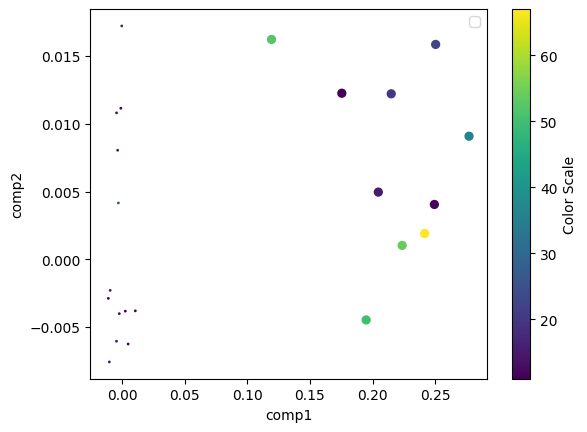

In [14]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [15]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.02988400389445167.
Iteration 1, inertia 0.022132917468622153.
Iteration 2, inertia 0.019989362041878206.
Converged at iteration 2: strict convergence.


Text(0, 0.5, 'comp2')

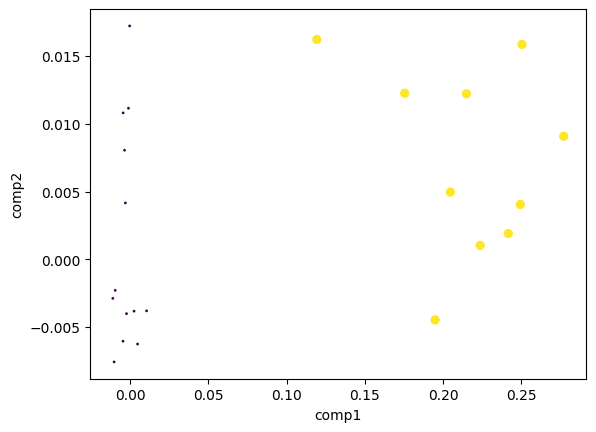

In [16]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [20]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].mean().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.head()

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,mt,cluster_prediction
6,0.250434,0.015862,SRR5892449.16013,23,42906,7,32,1
7,0.194896,-0.004475,SRR5892449.18856,50,42640,8,32,1
10,0.214927,0.012217,SRR5892449.4276,20,40403,11,32,1
17,0.204622,0.004961,SRR5892449.17340,15,38289,18,32,1
21,0.175464,0.012258,SRR5892449.21564,11,37081,22,32,1


In [18]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/mt_reads_v1.fasta')

340 reads retrieved
